In [2]:
!pip3 install seaborn
!pip3 install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm

In [4]:
# Read diamonds_ece219.csv

# Read the CSV file
df = pd.read_csv('diamonds_ece219.csv')
df = df.drop("Unnamed: 0", axis=1)
df.head()

,color,clarity,carat,cut,symmetry,polish,depth_percent,table_percent,length,width,depth,girdle_min,girdle_max,price
0,E,VVS2,0.09,Excellent,Very Good,Very Good,62.7,59.0,2.85,2.87,1.79,M,M,200
1,E,VVS2,0.09,Very Good,Very Good,Very Good,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,E,VVS2,0.09,Excellent,Very Good,Very Good,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,E,VVS2,0.09,Excellent,Very Good,Very Good,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,E,VVS2,0.09,Very Good,Very Good,Excellent,64.9,58.5,2.79,2.83,1.82,STK,STK,200


In [5]:
# print the column names
print(df.columns)

Index(['color', 'clarity', 'carat', 'cut', 'symmetry', 'polish',
       'depth_percent', 'table_percent', 'length', 'width', 'depth',
       'girdle_min', 'girdle_max', 'price'],
      dtype='object')


## Feature Engineering

### Handling Categorical Features

In [6]:
# figure out the categorical variables
categorical = df.select_dtypes(include=['object'])
print(categorical.head())


  color clarity        cut   symmetry     polish girdle_min girdle_max
0     E    VVS2  Excellent  Very Good  Very Good          M          M
1     E    VVS2  Very Good  Very Good  Very Good        STK        STK
2     E    VVS2  Excellent  Very Good  Very Good         TN          M
3     E    VVS2  Excellent  Very Good  Very Good          M        STK
4     E    VVS2  Very Good  Very Good  Excellent        STK        STK


In [7]:
#Q3.1.1

encoder = OneHotEncoder(sparse_output=False)

categorical_columns = [
    "color", "clarity", "cut", "symmetry", "polish", "girdle_min", "girdle_max",
]
numeric_columns = [
    "carat", "depth_percent", "table_percent", "length", "width", "depth", "price",
]

# One hot encode categorical columns
encoded_data = encoder.fit_transform(df[categorical_columns])
categorical_names = encoder.get_feature_names_out(categorical_columns)
categorical_df = pd.DataFrame(encoded_data, columns=categorical_names)

# Extract numeric columns
numeric_df = df[numeric_columns]

# Concatenate columns for final dataset
df_processed = pd.concat([numeric_df, categorical_df], axis=1)

In [8]:
df_processed.head()

,carat,depth_percent,table_percent,length,width,depth,price,color_D,color_E,color_F,...,girdle_max_M,girdle_max_STK,girdle_max_STN,girdle_max_TK,girdle_max_TN,girdle_max_VTK,girdle_max_VTN,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown
0,0.09,62.7,59.0,2.85,2.87,1.79,200,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.09,61.9,59.0,2.84,2.89,1.78,200,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.09,61.1,59.0,2.88,2.90,1.77,200,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.09,62.0,59.0,2.86,2.88,1.78,200,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.09,64.9,58.5,2.79,2.83,1.82,200,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Question 1.1

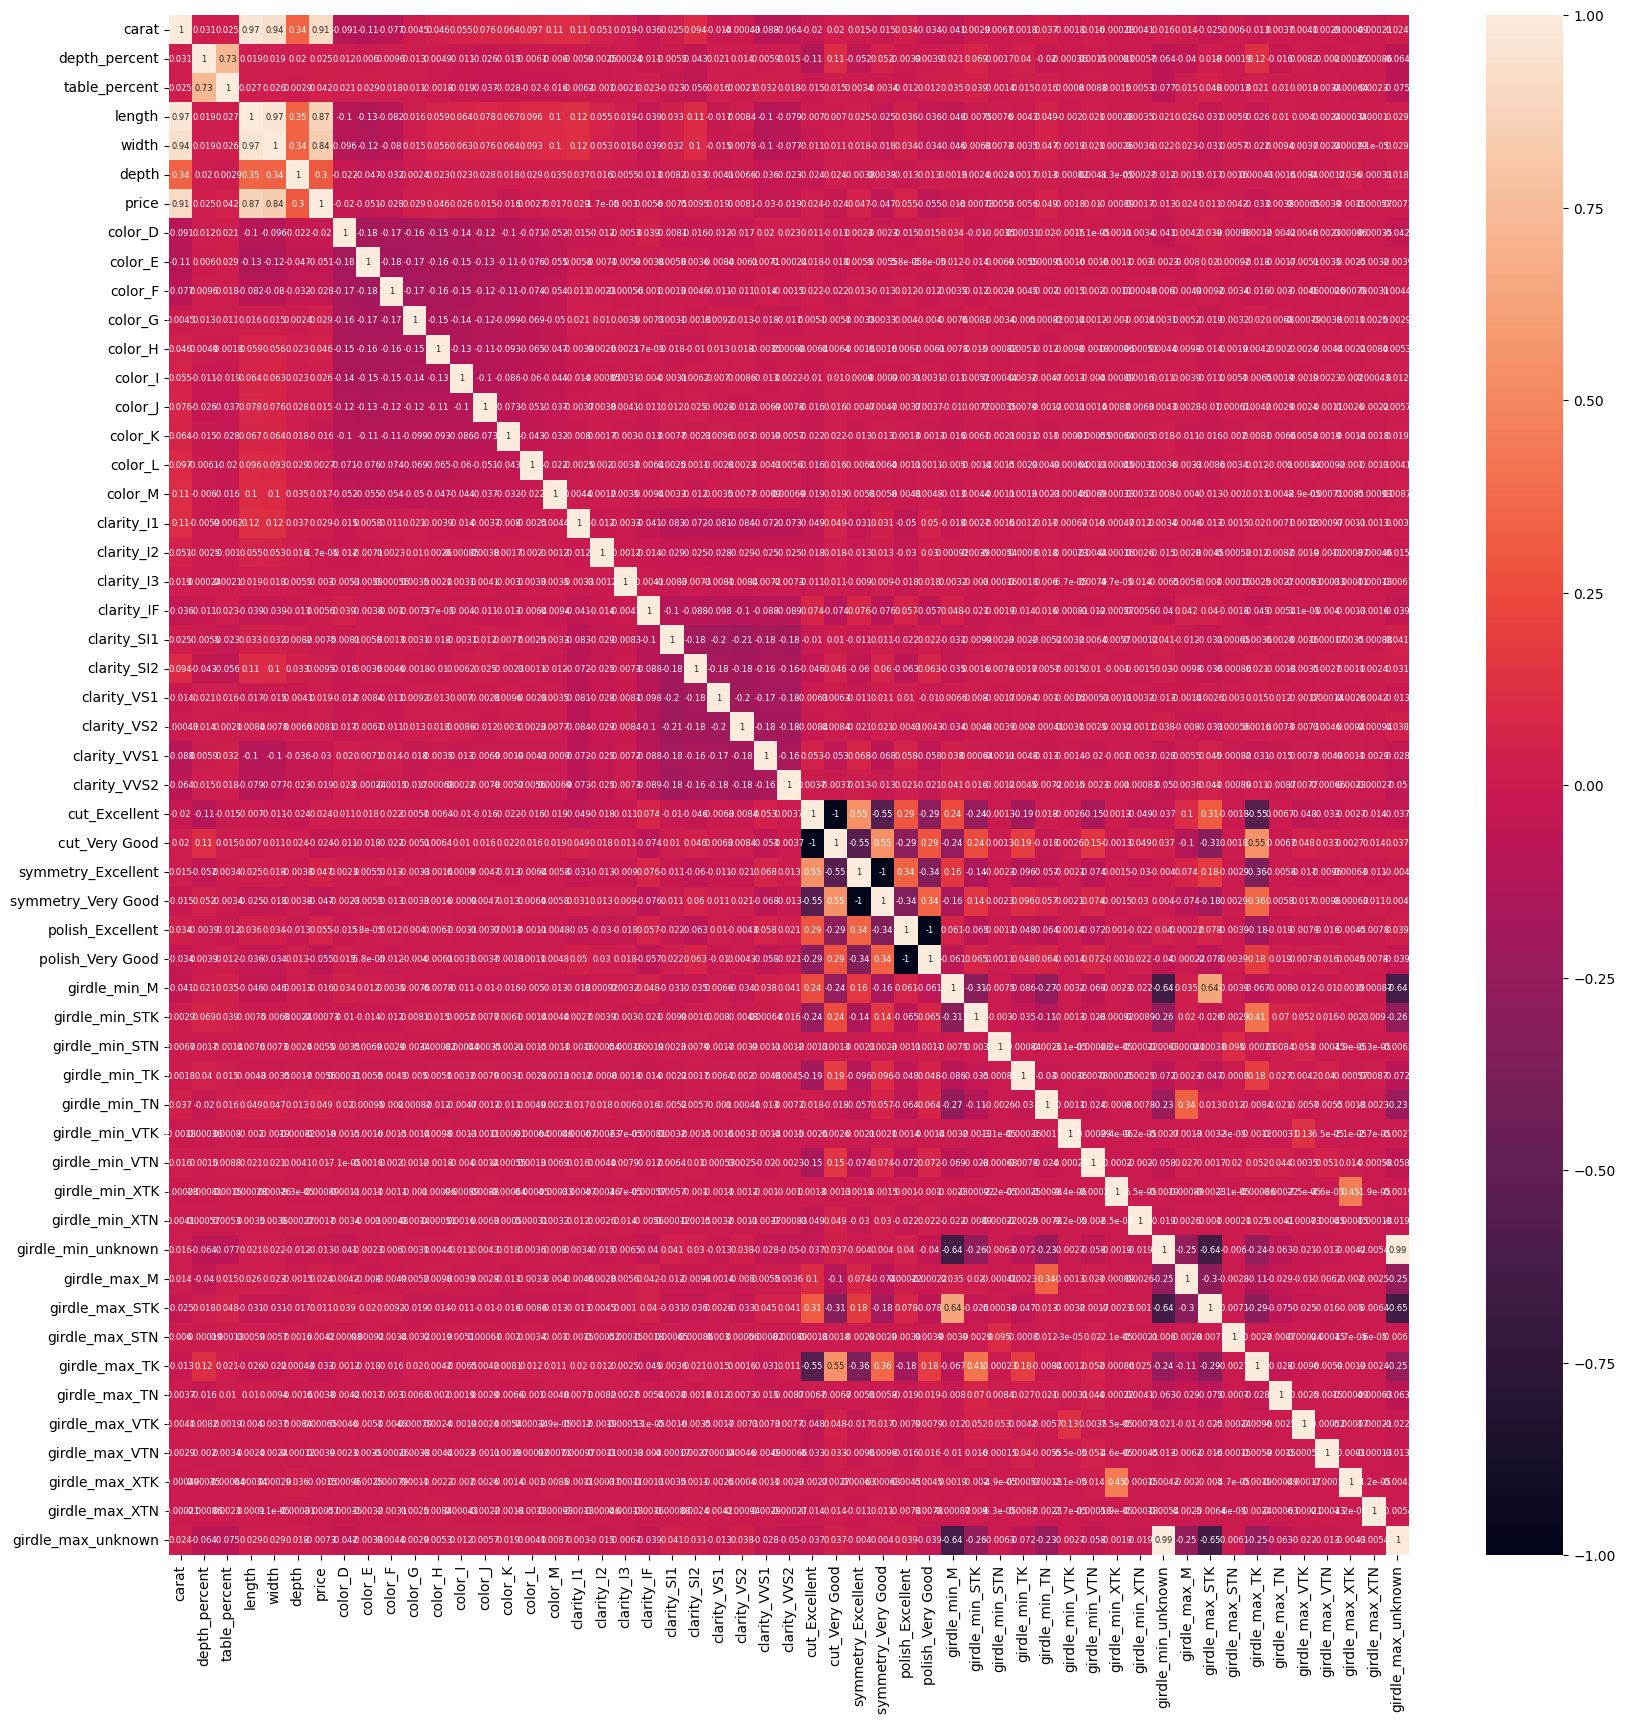

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
sn.heatmap(df_processed.corr(), annot=True, annot_kws={"size": 6})
plt.show()


### Question 1.2

For high skewness, we could apply natural log transform to reduce the right skew. When a variable has a right-skewed distribution, it typically has a heavy tail with a small number of very large values. A log transformation compresses those larger values more than the smaller ones, pulling in the tail of the distribution. Because of that compression effect, the distribution’s tail becomes shorter or “closer” to the rest of the data, reducing the overall skew. If the data roughly span several orders of magnitude, log-transforming often shifts the distribution closer to a normal-like shape.

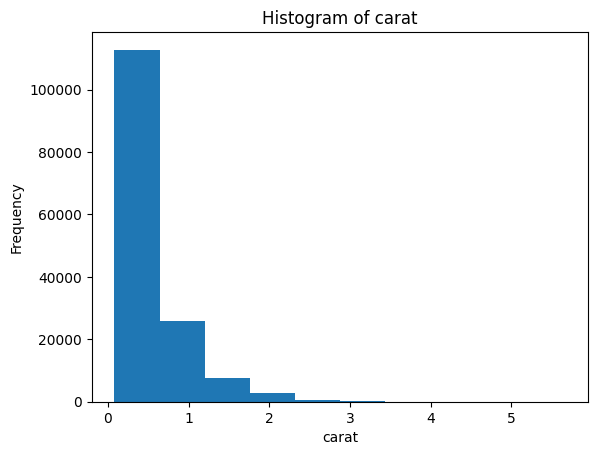

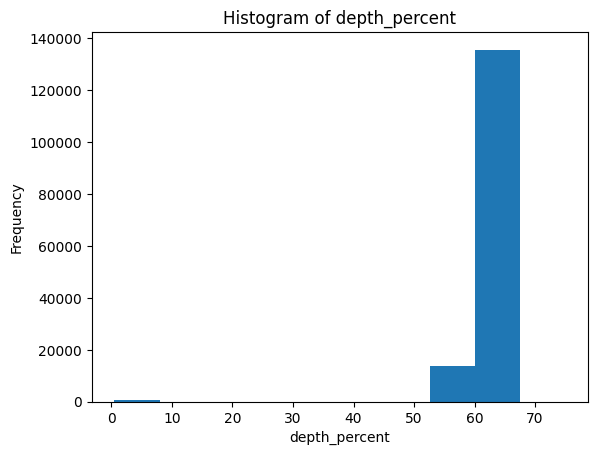

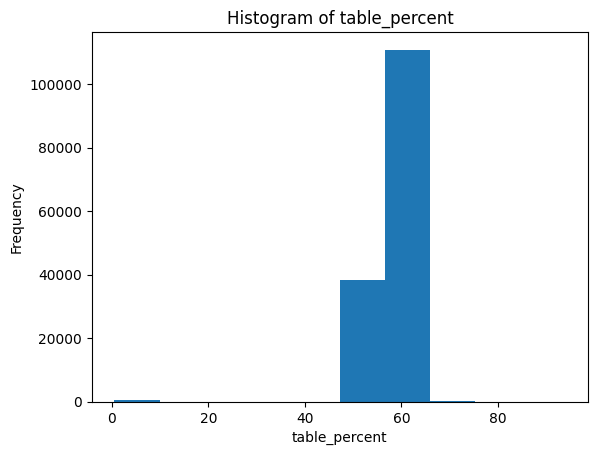

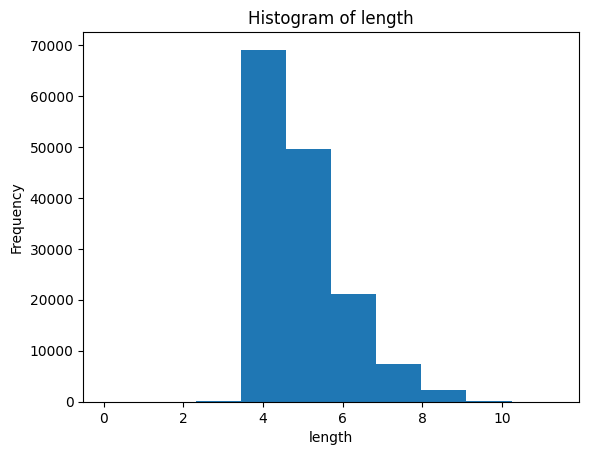

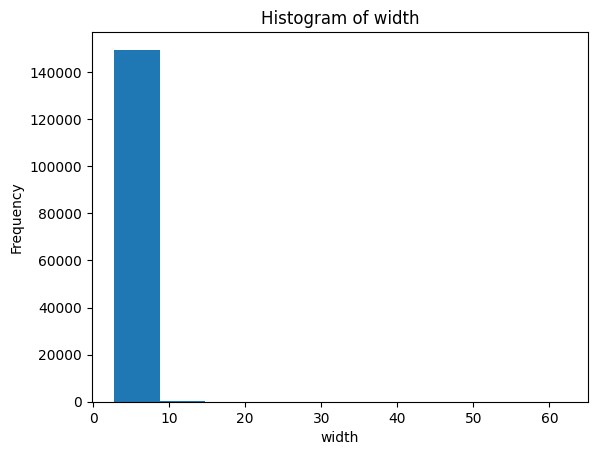

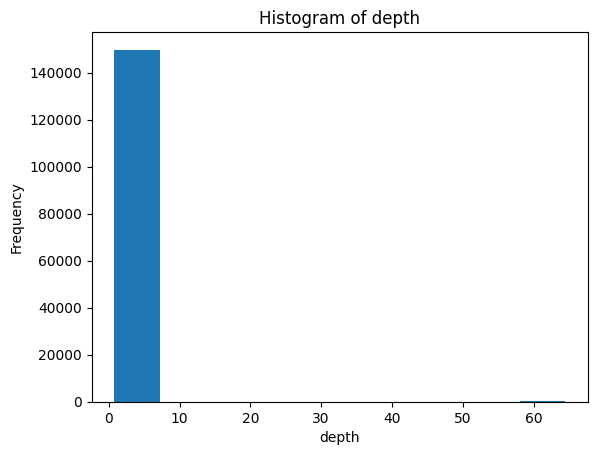

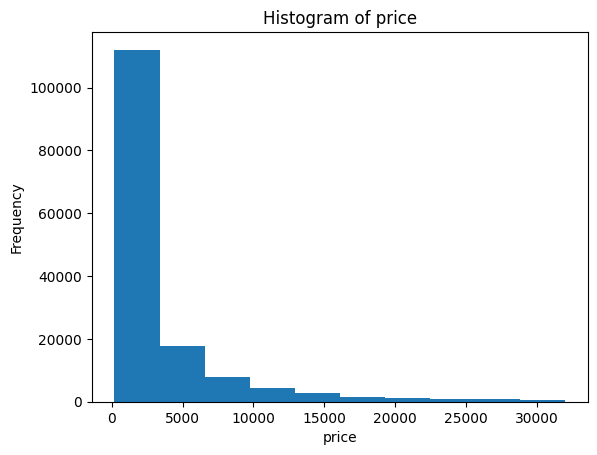

In [10]:
#histogram of numerical features
for feature in numeric_columns:
    plt.figure()
    plt.hist(df_processed[feature], bins=10)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature}")
    plt.show()

### Question 1.3

One key finding is that for each category, across all its possible values, there are numerous outliers. For instance, girdle_min consistently shows many outliers regardless of the specific girdle_min value. This suggests that these individual categorical features don’t reliably predict price on their own. For example, even if a diamond’s polish is rated “Excellent,” it doesn’t necessarily narrow the overall price range. That said, there are a few features and particular values that seem more closely tied to price. Specifically, for girdle_max, the “STN” and “XTK” categories, and for girdle_min, the “VTK” and “XTK” categories. In these cases, if a diamond falls under one of these categories—say, if it has an extra thick max girdle—its price tends to be lower, and there are fewer outliers in that group

<Figure size 640x480 with 0 Axes>

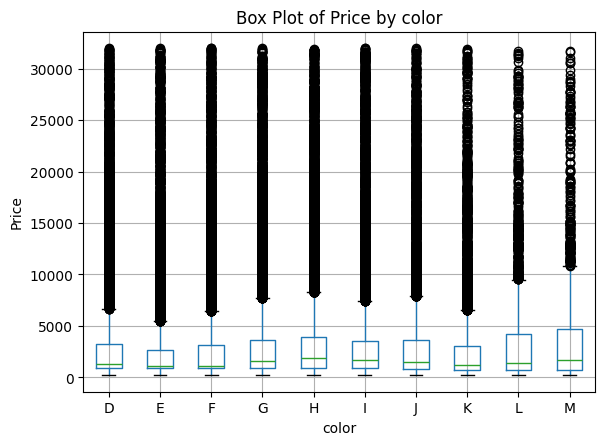

<Figure size 640x480 with 0 Axes>

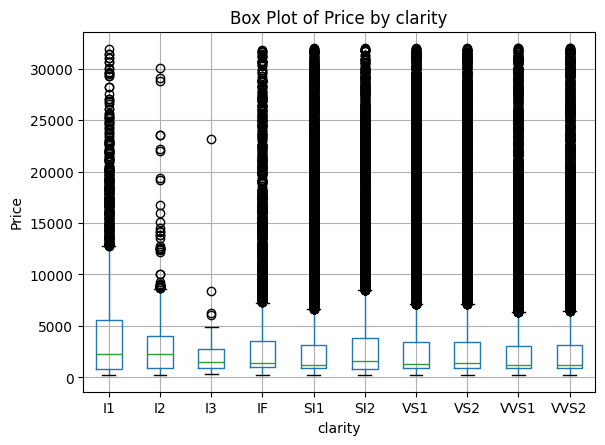

<Figure size 640x480 with 0 Axes>

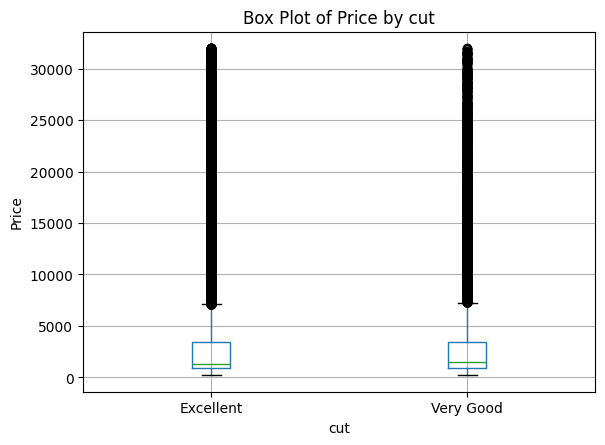

<Figure size 640x480 with 0 Axes>

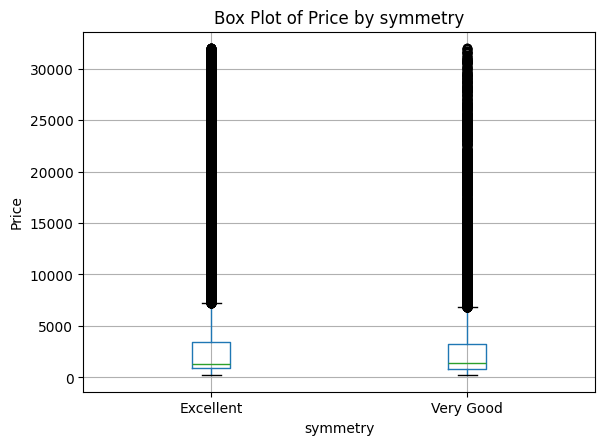

<Figure size 640x480 with 0 Axes>

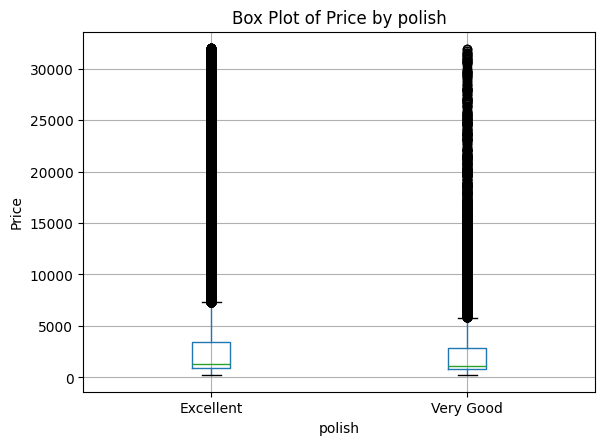

<Figure size 640x480 with 0 Axes>

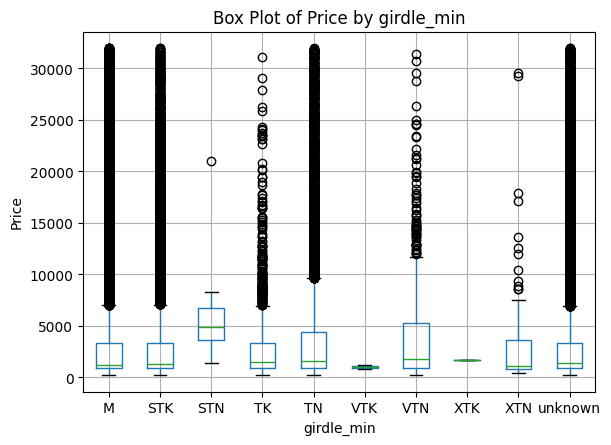

<Figure size 640x480 with 0 Axes>

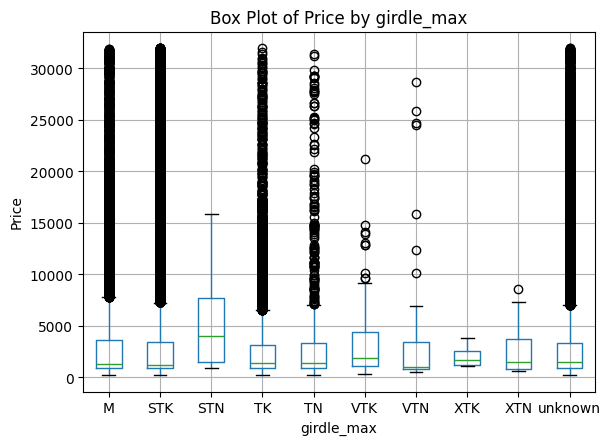

In [11]:
for cat_col in categorical_columns:
    plt.figure()
    df.boxplot(column="price", by=cat_col)
    plt.title(f"Box Plot of Price by {cat_col}")
    plt.suptitle("")  # Remove default title
    plt.xlabel(cat_col)
    plt.ylabel("Price")
    plt.show()

### Question 1.4

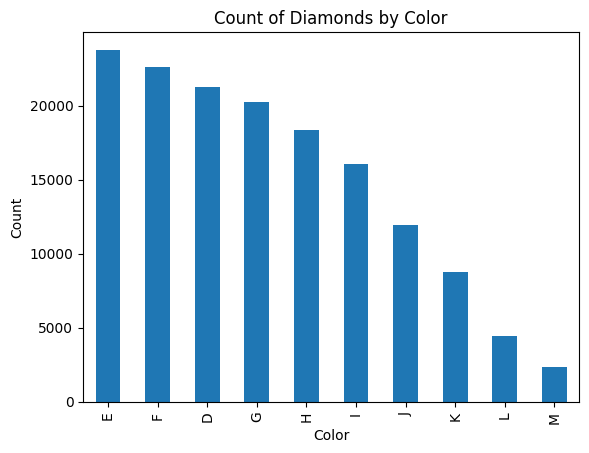

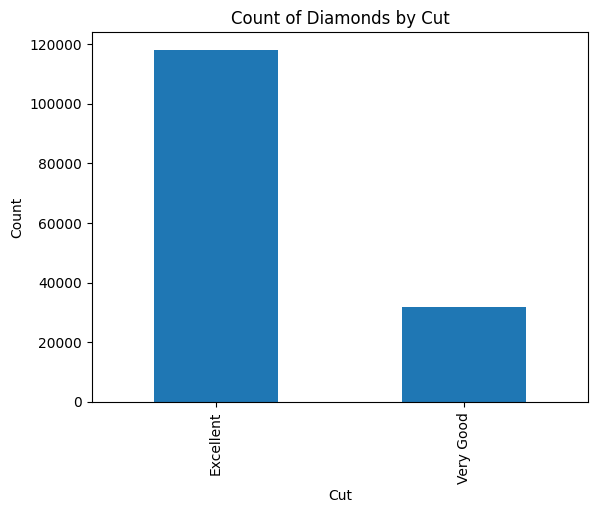

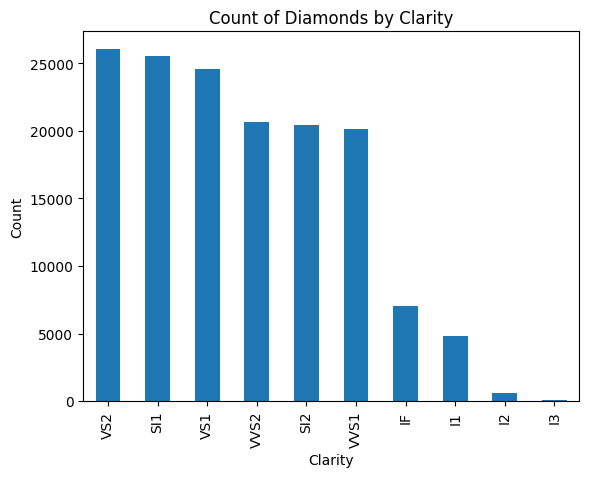

In [12]:
#plot the counts by color, cut and clarity
for var in ["color", "cut", "clarity"]:
    plt.figure()
    df[var].value_counts().plot(kind="bar")
    plt.title(f"Count of Diamonds by {var.capitalize()}")
    plt.xlabel(var.capitalize())
    plt.ylabel("Count")
    plt.show()

### Question 2.1

In [13]:
#standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(scaled_data, columns=df_processed.columns)

df_scaled.head()

,carat,depth_percent,table_percent,length,width,depth,price,color_D,color_E,color_F,...,girdle_max_M,girdle_max_STK,girdle_max_STN,girdle_max_TK,girdle_max_TN,girdle_max_VTK,girdle_max_VTN,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown
0,-1.157106,0.215866,0.345119,-2.146391,-2.078247,-0.730430,-0.659094,-0.406722,2.302809,-0.421735,...,2.909902,-0.873049,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
1,-1.157106,0.014689,0.345119,-2.156289,-2.059209,-0.735681,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
2,-1.157106,-0.186488,0.345119,-2.116697,-2.049690,-0.740932,-0.659094,-0.406722,2.302809,-0.421735,...,2.909902,-0.873049,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
3,-1.157106,0.039836,0.345119,-2.136493,-2.068728,-0.735681,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
4,-1.157106,0.769101,0.218693,-2.205778,-2.116324,-0.714676,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798


In [14]:
#prepare for training
X = df_scaled.drop("price", axis=1)
y = df_scaled["price"]

### Question 2.2

Feature selection can significantly influence model performance by removing irrelevant or weakly correlated features, which can reduce noise during training and help prevent overfitting—thereby often improving generalization and lowering test RMSE. With fewer features, classical models such as Linear Regression, Ridge, Lasso, and tree-based methods tend to train faster, produce simpler solutions, and become more interpretable, especially for linear models where each feature’s contribution can be readily understood. However, feature selection may not provide the same benefit for all model types. Deep neural networks, for instance, can inherently “ignore” less informative features by learning appropriate internal weights, particularly when large datasets are available. Similarly, models with built-in regularization (e.g., Lasso or Ridge) already penalize unimportant features, reducing the need for extensive manual feature selection. Nonetheless, most classical models stand to gain the most in terms of reduced overfitting and improved interpretability when strong feature selection techniques are applied.

In [15]:
# Calculate Mutual Information for each feature
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=True)
# Get the two features with the lowest MI
lowest_mi_features = mi_series.head(2)
print("Lowest MI Features:")
print(lowest_mi_features)

Lowest MI Features:
girdle_max_STN    0.0
girdle_min_STN    0.0
dtype: float64


### Question 2.3

In [16]:
# Sort MI scores in descending order
mi_series_sorted = mi_series.sort_values(ascending=False)

# Identify the top 4 features
top_4_features = mi_series_sorted.head(4)
print("Top 4 features with the highest Mutual Information:")
print(top_4_features)

Top 4 features with the highest Mutual Information:
carat     1.373490
width     1.203990
length    1.191706
depth     1.157094
dtype: float64


### OLS

In [78]:
#Set up cross validation
X = df_scaled[top_4_features.index].values
y = df_scaled["price"].values
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

print(f"KFold RMSE Scores using OLS: {rmse_scores}")
print(f"Average RMSE using OLS: {mean_rmse:.4f}")
print("OLS Learned Parameters:", model.coef_)

/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

KFold RMSE Scores using OLS: [0.4043157042400065, 0.39673297145375686, 0.39038199831098475, 0.39687345549549646, 0.40584014231894255, 0.4165553623833117, 0.3881531507252115, 0.39430078934083795, 0.3986271371834867, 0.4018437522538862]
Average RMSE using OLS: 0.3994
OLS Learned Parameters: [ 1.23321638 -0.00638228 -0.32284683 -0.00313035]


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Lasso Regression

In [33]:
from sklearn.linear_model import LassoCV

# Define a range of alpha values
alphas = np.logspace(-2, 2, 100)

# Initialize Lasso with automatic alpha selection
lasso_cv = LassoCV(alphas=alphas, cv=10)  # 5-Fold Cross Validation
lasso_cv.fit(X, y)

# Best alpha found
best_alpha = lasso_cv.alpha_
print(f"Optimal alpha for Lasso: {best_alpha:.4f}")


Optimal alpha for Lasso: 0.0100


In [35]:
#Set up cross validation
X = df_scaled[top_4_features.index].values
y = df_scaled["price"].values
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Lasso(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

print(f"KFold RMSE Scores using Lasso: {rmse_scores}")
print(f"Average RMSE using Lasso: {mean_rmse:.4f}")
print("Lasso Learned Parameters:", model.coef_)

/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

KFold RMSE Scores using Lasso: [0.41096875171912445, 0.404556113179265, 0.39762096241272443, 0.40537309829155166, 0.4170268495159163, 0.41986032716778365, 0.3942322425399875, 0.4044817669830297, 0.40508899741064136, 0.4104807423284689]
Average RMSE using Lasso: 0.4070
Lasso Learned Parameters: [ 0.90255906 -0.         -0.         -0.        ]


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Ridge regression

In [49]:
from sklearn.linear_model import RidgeCV

X = df_scaled[top_4_features.index].values
y = df_scaled["price"].values

# Define a range of alpha values
alphas = np.logspace(-2, 2, 100)

# Initialize Ridge with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X, y)

# Best alpha found
best_alpha = ridge_cv.alpha_
print(f"Optimal alpha for Ridge: {best_alpha:.4f}")

Optimal alpha for Ridge: 0.0100


In [38]:
#Set up cross validation
X = df_scaled[top_4_features.index].values
y = df_scaled["price"].values
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Ridge(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

print(f"KFold RMSE Scores using Ridge: {rmse_scores}")
print(f"Average RMSE using Ridge: {mean_rmse:.4f}")
print("Ridge Learned Parameters:", model.coef_)

KFold RMSE Scores using Ridge: [0.4043157029108119, 0.39673296884533954, 0.3903819942905589, 0.39687346211873525, 0.4058401732861975, 0.4165553305501563, 0.3881531426461644, 0.39430081015926866, 0.398627127992626, 0.4018437542265814]
Average RMSE using Ridge: 0.3994
Ridge Learned Parameters: [ 1.2332143  -0.00638258 -0.32284448 -0.00313037]


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To

### Compare with no standardization

In [59]:
X_unscaled = df_processed.drop("price", axis=1)
y_unscaled = df_processed["price"]

X_unscaled_used = X_unscaled[top_4_features.index]

In [60]:
from sklearn.linear_model import RidgeCV

X_unscaled_used = X_unscaled_used.values
y_unscaled = y_unscaled.values

# Define a range of alpha values
alphas = np.logspace(-2, 2, 100)

# Initialize Ridge with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_unscaled_used, y_unscaled)

# Best alpha found
best_alpha = ridge_cv.alpha_
print(f"Optimal alpha for without standardization: {best_alpha:.4f}")

Optimal alpha for without standardization: 0.7221


In [69]:
#Set up cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X_unscaled_used):
    X_train, X_test = X_unscaled_used[train_index], X_unscaled_used[test_index]
    y_train, y_test = y_unscaled[train_index], y_unscaled[test_index]

    model = Ridge(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_scores.append(rmse)

mean_rmse = np.mean(rmse_scores)

print(f"KFold RMSE Scores using Ridge without standardization: {rmse_scores}")
print(f"Average RMSE using Ridge without standardization: {mean_rmse:.4f}")
print("Ridge Learned Parameters without standardization:", model.coef_)

KFold RMSE Scores using Ridge without standardization: [1904.0677211884415, 1868.3588402956452, 1838.4453530599174, 1869.0359341213205, 1911.3037675032672, 1961.6575130662686, 1827.9316817579872, 1856.9450519016993, 1877.2676181659908, 1892.4382086362775]
Average RMSE using Ridge without standardization: 1880.7452
Ridge Learned Parameters without standardization: [ 1.44759150e+04 -2.86840511e+01 -1.50127598e+03 -7.74876781e+00]


/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/zth/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To